In [1]:
# Wrangling raw data with find/replace regular expressions

In [2]:
# Select all the fields for the csv file. Note part of the entries do not have STAGEOUT_PILOTS.
#
# Headers
# DATE,TIME,ACTIVE_PILOTS,ALLOCATED_NODES,STAGEOUT_PILOTS,BF_NODES,BF_WALLTIME
# Find:    (^\d+.\d+.\d+) (\d+:\d+:\d+)[\r\n= ]+Number of active pilots: (\d+)\nNumber of allocated nodes: (\d+)\nAvailable( )resources\nNodes: (\d+), Walltime \(str\): [\w\d:]+, Walltime \(min\) (\d+)|(^\d+.\d+.\d+) (\d+:\d+:\d+)[\r\n= ]+Number of active pilots: (\d+)\nNumber of allocated nodes: (\d+)\nNumber of stage-out pilots: (\d+)\nAvailable resources\nNodes: (\d+), Walltime \(str\): [\w\d:]+, Walltime \(min\) (\d+)
# Replace: $1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12,$13,$14

# Replace empty fileds (TODO: refine previous regex)
# Find:    ,,,,,,,
# Replace: None

# Select all the fields for entries with more than one backfill polling.
# Find:    (^\d+.\d+.\d+),(\d+:\d+:\d+),(\d+),(\d+),(\d+| ),(\d+),(\d+)\nNodes: (\d+), Walltime \(str\): [\w\d:]+, Walltime \(min\) (\d+)
# Replace: $1,$2,$3,$4,$5,$6,$7\n$1,$2,$3,$4,$5,$8,$9

# Eliminate entries with no backfill polling.
# Find:    ^\d+.\d+.\d+ \d+:\d+:\d+[\r\n= ]+Number of [\w :\d\r\n-]+Available resources
# Replace: None

# Eliminate entries summarizing the total number of resources used.
# Find:    ^\d+.\d+.\d+ \d+:\d+:\d+[\r\n= ]+Number of active pilots: \d+[\r\n]+Number of allocated nodes: \d+
# Replace: None

# Clean up spurious newlines.
# Find:    ^\n
# Replace: None

# Replace empty space with empty entry in csv file.
# Find:    , ,
# Replace: ,,

# Analysis

In [28]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm
# import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

In [4]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
# mpl.rcParams['text.usetex'] = True 
# mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
# mpl.rcParams['axes.linewidth']    = 0.75
# mpl.rcParams['xtick.major.width'] = 0.75
# mpl.rcParams['xtick.minor.width'] = 0.75
# mpl.rcParams['ytick.major.width'] = 0.75
# mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
# mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,4))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

acquire raw data set.

In [5]:
bavail = pd.read_csv('backfill_resources_stat.csv', index_col=0)

Eliminate entries with 0 backfill availability as we do not need it to correlate number of worker nodes available and walltime.

In [6]:
bavail_clean = bavail.replace(to_replace=0, value=np.nan).rename_axis(None)
bavail_clean = bavail_clean.dropna()

Group availability by day and sum the availability for each day. Useful for a follow up plot not included in the paper submitted to Super Computing 2017.

In [7]:
bavail_grouped = bavail_clean.groupby(bavail_clean.index).sum()

# Correlation and distributions walltime/#nodes backfill availability 12-2015/2-2017 as measured by PanDA on Titan every ~10 minutes

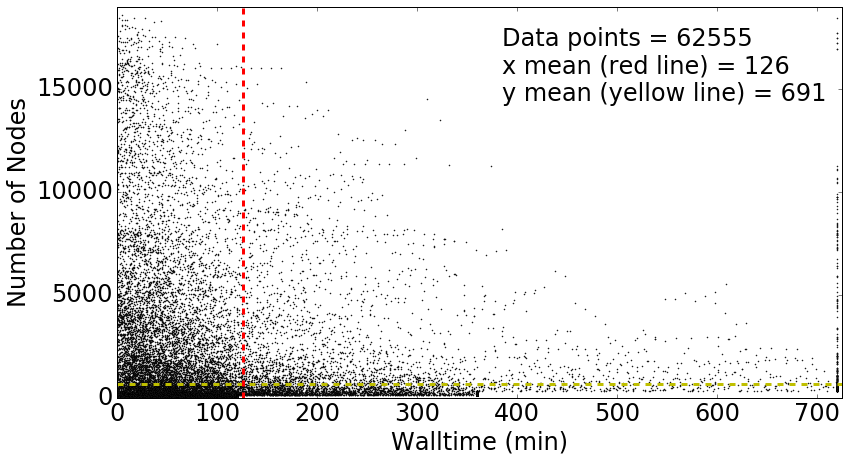

In [8]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

# title='TITAN Backfill Availability\n'+\
# 'Correlation between the number of nodes available and their walltime.'
# fig.suptitle(title)

qui = bavail_clean#[bavail_clean.WALLTIME < 720].copy()
ymean = qui.NODES.mean()
xmean = qui.WALLTIME.mean()

ax.scatter(qui['WALLTIME'], 
           qui['NODES'], 
           s=1, 
           facecolor='gray', lw=0.5)#, alpha=0.3, lw=0.5)

plt.axhline(qui.NODES.mean(), color='y', linestyle='dashed', linewidth=3)
plt.axvline(qui.WALLTIME.mean(), color='r', linestyle='dashed', linewidth=3)

mpl.pyplot.text(0.53, 0.95, "Data points = %s\nx mean (red line) = %s\ny mean (yellow line) = %s" % (qui.shape[0], int(xmean), int(ymean)),
    horizontalalignment='left',
    verticalalignment='top',
    transform = ax.transAxes,
    fontsize=24)

ax.set_xlim(0,725)
ax.set_ylim(0,19000)

plt.xlabel('Walltime (min)')
plt.ylabel('Number of Nodes')

plt.savefig('titan_backfill_avail.pdf', dpi=300, bbox_inches='tight')
plt.savefig('titan_backfill_avail.png', dpi=300, bbox_inches='tight')

(0, 1200.0)

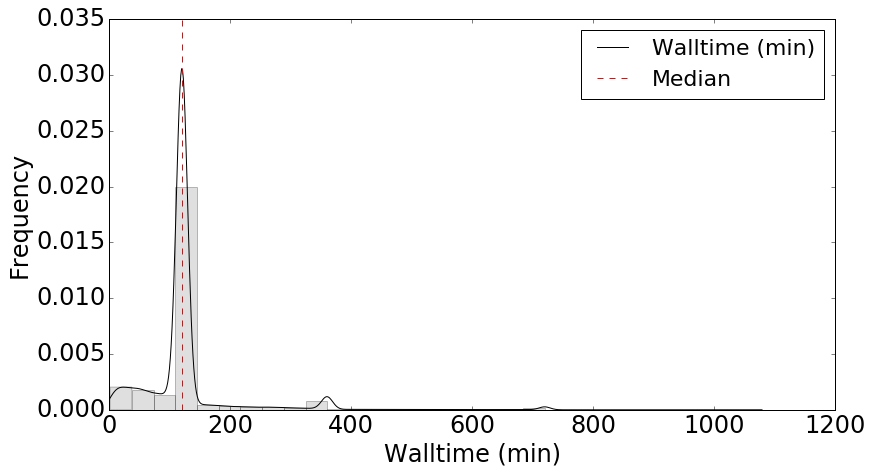

In [9]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

qui[['WALLTIME']].reset_index(drop=True).plot.density(ax=ax, 
    color='black')

qui[['WALLTIME']].reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=20, 
                alpha = 0.25,
                normed=True)

plt.axvline(qui.WALLTIME.median(), color='r', linestyle='dashed', linewidth=1)

ax.legend(labels=['Walltime (min)', 'Median'])
plt.xlabel('Walltime (min)')
ax.set_xlim(0)


(0, 2000)

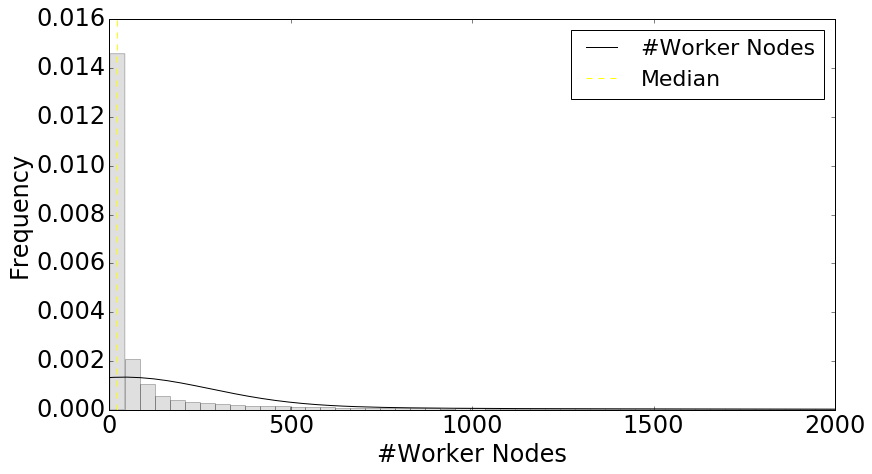

In [10]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

qui[['NODES']].reset_index(drop=True).plot.density(ax=ax, 
    color='black')

qui[['NODES']].reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=450, 
                alpha = 0.25,
                normed=True)

plt.axvline(qui.NODES.median(), color='yellow', linestyle='dashed', linewidth=1)

ax.legend(labels=['#Worker Nodes', 'Median'])
plt.xlabel('#Worker Nodes')
ax.set_xlim(0,2000)


## Breakdown means, correlation and distributions per scheduler's bin of Titan

Segmentation of scheduling policies on Titan:

|Bin|Min Nodes|Max Nodes|Max Walltime (Hours)|Aging Boost (Days)|
|---|---------|------------------------------|------------------|
|1 	|11,250   |	— 	    |24.0 	             |15                |
|2 	|3,750 	  |11,249 	|24.0 	             |5                 |
|3 	|313 	  |3,749 	|12.0 	             |0                 |
|4 	|126 	  |312 	    |6.0 	             |0                 |
|5 	|1 	      |125 	    |2.0 	             |0                 |

In [11]:
segments = {
    '5th bin\n1-125\nNodes': bavail_clean[(bavail_clean.NODES >= 1   ) & (bavail_clean.NODES < 126)  ],
    '4th bin\n126-312\nNodes': bavail_clean[(bavail_clean.NODES >= 126 ) & (bavail_clean.NODES < 313)  ],
    '3rd bin\n313-3749\nNodes': bavail_clean[(bavail_clean.NODES >= 313 ) & (bavail_clean.NODES < 3750) ],
    '2nd bin\n3750-11249\nNodes': bavail_clean[(bavail_clean.NODES >= 3750) & (bavail_clean.NODES < 11250)],
    '1st bin\n11250-\nNodes': bavail_clean[ bavail_clean.NODES >= 11250]
}

Availability per scheduling bin.

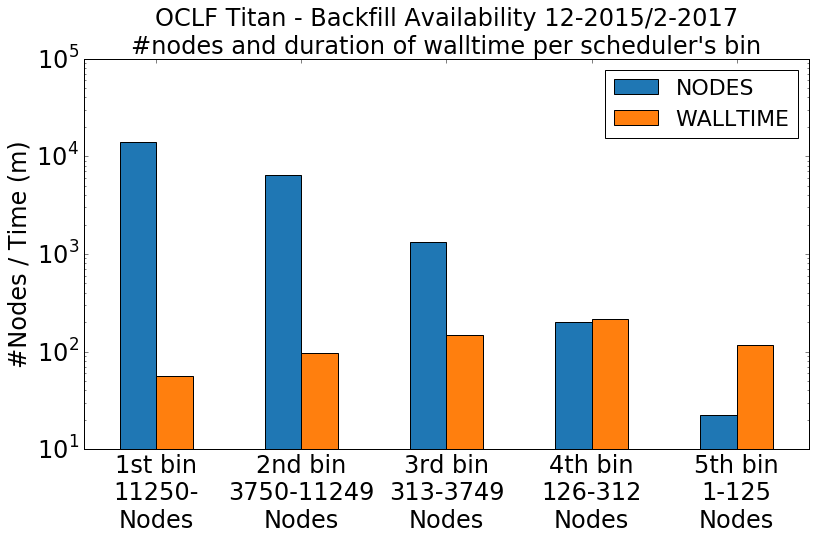

In [12]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

title = 'OCLF Titan - Backfill Availability 12-2015/2-2017\n#nodes and duration of walltime per scheduler\'s bin'

# Get medians for each segment and transpose them back to a df
means = [v.mean().to_frame(name=k).transpose() for k,v in segments.iteritems()]

# Concatenate segments' DFs into a single DF
segments_means = pd.concat(means)

# Plot segments' means into a stacked bar graph
segments_means.sort_index().plot.bar(ax=ax, color=[tableau20[0],tableau20[2]], rot=0, title=title)#, stacked=True)

ax.set_yscale('log', basex=2)
ax.set_ylabel('#Nodes / Time (m)')

## Correlation and distributions for the 1st bin

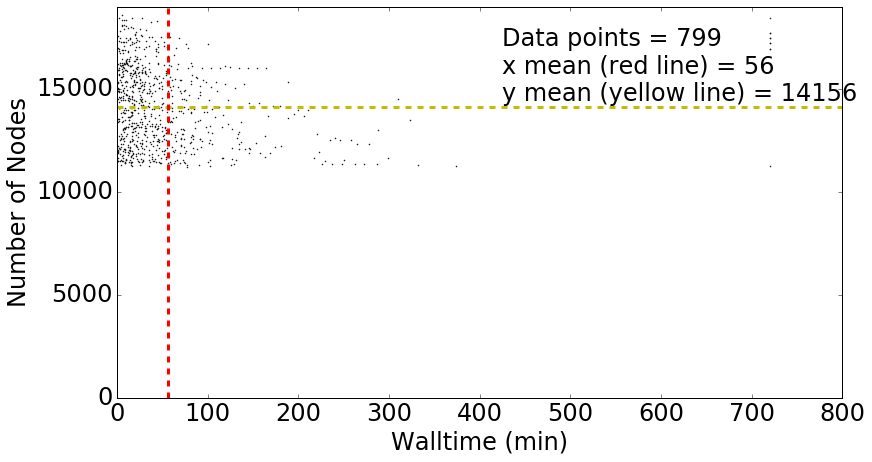

In [13]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

# title='TITAN Backfill Availability\n'+\
# 'Correlation between the number of nodes available and their walltime.'
# fig.suptitle(title)

quo = segments['1st bin\n11250-\nNodes']
ymean = quo.NODES.mean()
xmean = quo.WALLTIME.mean()

ax.scatter(quo['WALLTIME'], 
           quo['NODES'], 
           s=1, 
           facecolor='gray', lw=0.5)#, alpha=0.3, lw=0.5)

plt.axhline(quo.NODES.mean(), color='y', linestyle='dashed', linewidth=3)
plt.axvline(quo.WALLTIME.mean(), color='r', linestyle='dashed', linewidth=3)

mpl.pyplot.text(0.53, 0.95, "Data points = %s\nx mean (red line) = %s\ny mean (yellow line) = %s" % (quo.shape[0], int(xmean), int(ymean)),
    horizontalalignment='left',
    verticalalignment='top',
    transform = ax.transAxes,
    fontsize=24)

ax.set_xlim(0)
ax.set_ylim(0)

plt.xlabel('Walltime (min)')
plt.ylabel('Number of Nodes')

plt.savefig('titan_backfill_avail_1000.pdf', dpi=300, bbox_inches='tight')
plt.savefig('titan_backfill_avail_1000.png', dpi=300, bbox_inches='tight')

(0, 1200.0)

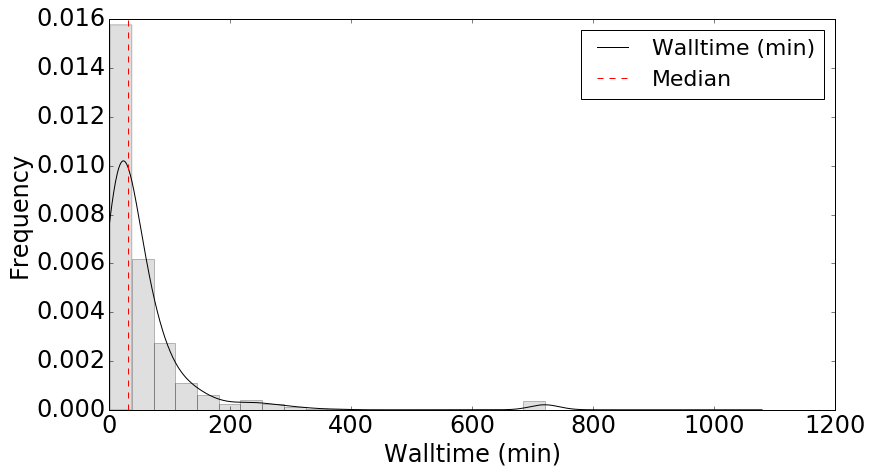

In [14]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

quo[['WALLTIME']].reset_index(drop=True).plot.density(ax=ax, 
    color='black')

quo[['WALLTIME']].reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=20, 
                alpha = 0.25,
                normed=True)

plt.axvline(quo.WALLTIME.median(), color='r', linestyle='dashed', linewidth=1)

ax.legend(labels=['Walltime (min)', 'Median'])
plt.xlabel('Walltime (min)')
ax.set_xlim(0)


(0, 24000.0)

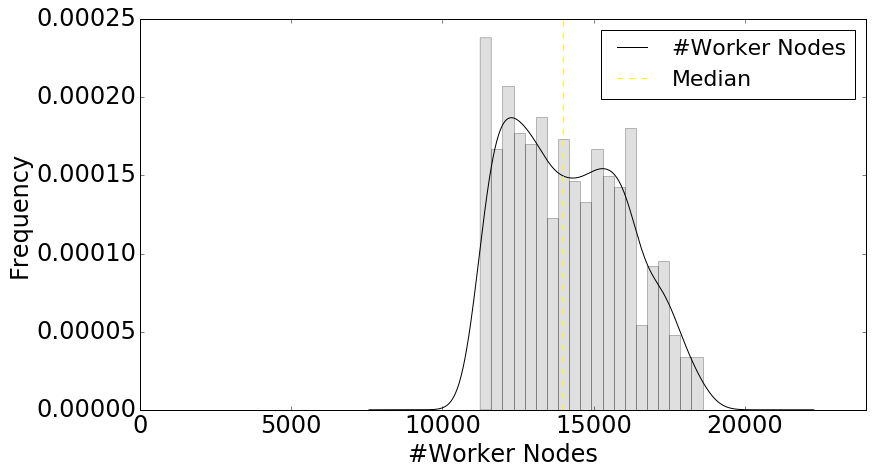

In [15]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

quo[['NODES']].reset_index(drop=True).plot.density(ax=ax, color='black')

quo[['NODES']].reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=20, 
                alpha = 0.25,
                normed=True)

plt.axvline(quo.NODES.median(), color='yellow', linestyle='dashed', linewidth=1)

ax.legend(labels=['#Worker Nodes', 'Median'])
plt.xlabel('#Worker Nodes')
ax.set_xlim(0)


## Correlation and distributions 2nd bin

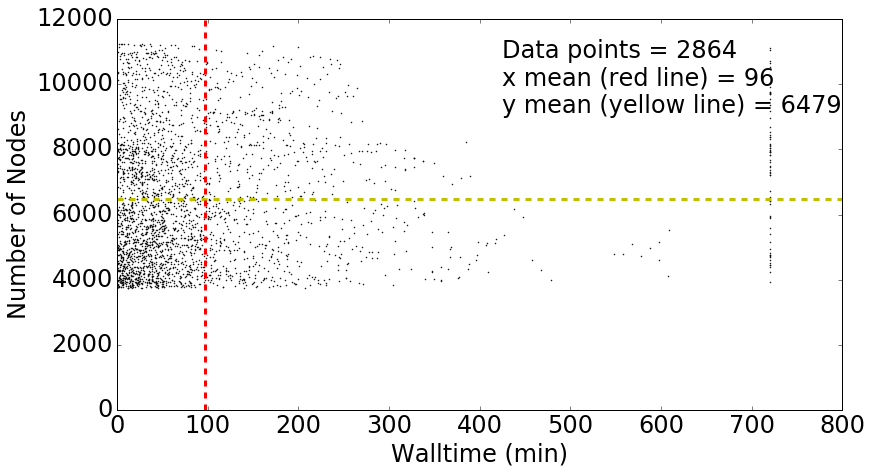

In [16]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

# title='TITAN Backfill Availability\n'+\
# 'Correlation between the number of nodes available and their walltime.'
# fig.suptitle(title)

quo = segments['2nd bin\n3750-11249\nNodes']
ymean = quo.NODES.mean()
xmean = quo.WALLTIME.mean()

ax.scatter(quo['WALLTIME'], 
           quo['NODES'], 
           s=1, 
           facecolor='gray', lw=0.5)#, alpha=0.3, lw=0.5)

plt.axhline(quo.NODES.mean(), color='y', linestyle='dashed', linewidth=3)
plt.axvline(quo.WALLTIME.mean(), color='r', linestyle='dashed', linewidth=3)

mpl.pyplot.text(0.53, 0.95, "Data points = %s\nx mean (red line) = %s\ny mean (yellow line) = %s" % (quo.shape[0], int(xmean), int(ymean)),
    horizontalalignment='left',
    verticalalignment='top',
    transform = ax.transAxes,
    fontsize=24)

ax.set_xlim(0)
ax.set_ylim(0)

plt.xlabel('Walltime (min)')
plt.ylabel('Number of Nodes')

plt.savefig('titan_backfill_avail_1000.pdf', dpi=300, bbox_inches='tight')
plt.savefig('titan_backfill_avail_1000.png', dpi=300, bbox_inches='tight')

(0, 1200.0)

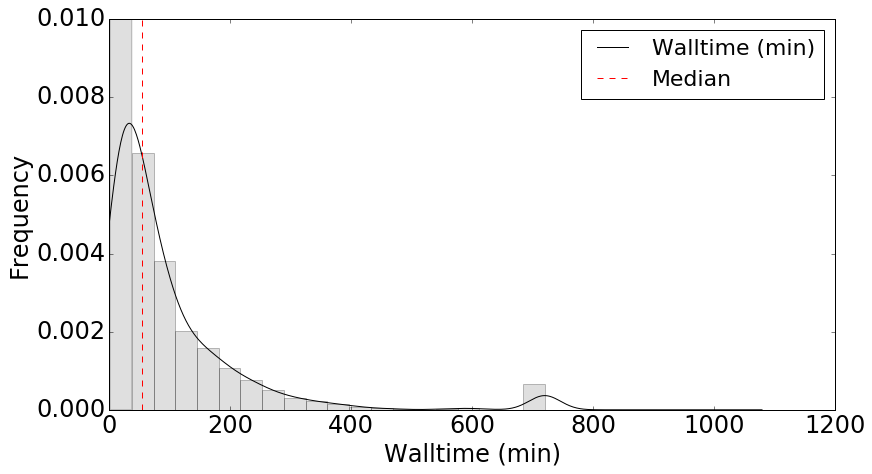

In [17]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

quo[['WALLTIME']].reset_index(drop=True).plot.density(ax=ax, 
    color='black')

quo[['WALLTIME']].reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=20, 
                alpha = 0.25,
                normed=True)

plt.axvline(quo.WALLTIME.median(), color='r', linestyle='dashed', linewidth=1)

ax.legend(labels=['Walltime (min)', 'Median'])
plt.xlabel('Walltime (min)')
ax.set_xlim(0)


(0, 16000.0)

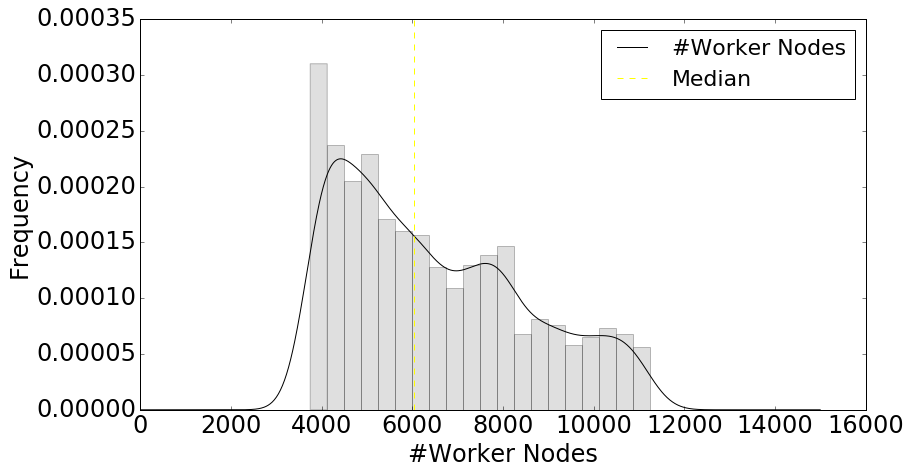

In [18]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

quo[['NODES']].reset_index(drop=True).plot.density(ax=ax, color='black')

quo[['NODES']].reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=20, 
                alpha = 0.25,
                normed=True)

plt.axvline(quo.NODES.median(), color='yellow', linestyle='dashed', linewidth=1)

ax.legend(labels=['#Worker Nodes', 'Median'])
plt.xlabel('#Worker Nodes')
ax.set_xlim(0)


## Correlation and distributions 3rd bin

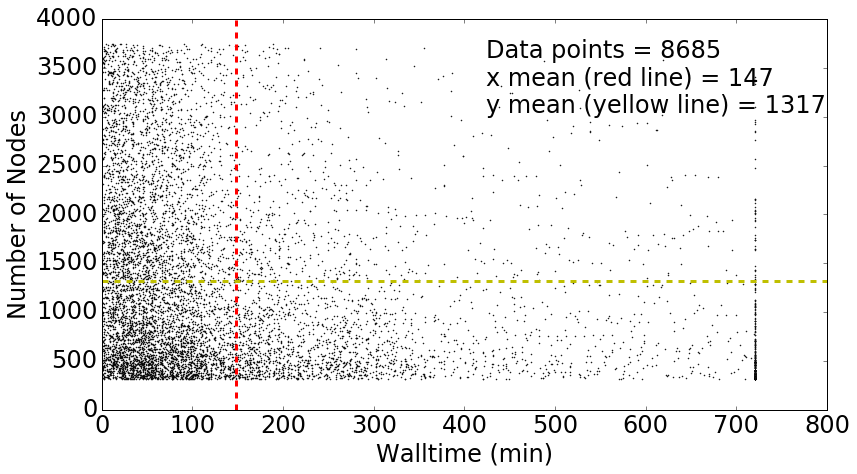

In [19]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

# title='TITAN Backfill Availability\n'+\
# 'Correlation between the number of nodes available and their walltime.'
# fig.suptitle(title)

quo = segments['3rd bin\n313-3749\nNodes']
ymean = quo.NODES.mean()
xmean = quo.WALLTIME.mean()

ax.scatter(quo['WALLTIME'], 
           quo['NODES'], 
           s=1, 
           facecolor='gray', lw=0.5)#, alpha=0.3, lw=0.5)

plt.axhline(quo.NODES.mean(), color='y', linestyle='dashed', linewidth=3)
plt.axvline(quo.WALLTIME.mean(), color='r', linestyle='dashed', linewidth=3)

mpl.pyplot.text(0.53, 0.95, "Data points = %s\nx mean (red line) = %s\ny mean (yellow line) = %s" % (quo.shape[0], int(xmean), int(ymean)),
    horizontalalignment='left',
    verticalalignment='top',
    transform = ax.transAxes,
    fontsize=24)

ax.set_xlim(0)
ax.set_ylim(0)

plt.xlabel('Walltime (min)')
plt.ylabel('Number of Nodes')

plt.savefig('titan_backfill_avail_3rd_bin.png', dpi=300, bbox_inches='tight')

(0, 1200.0)

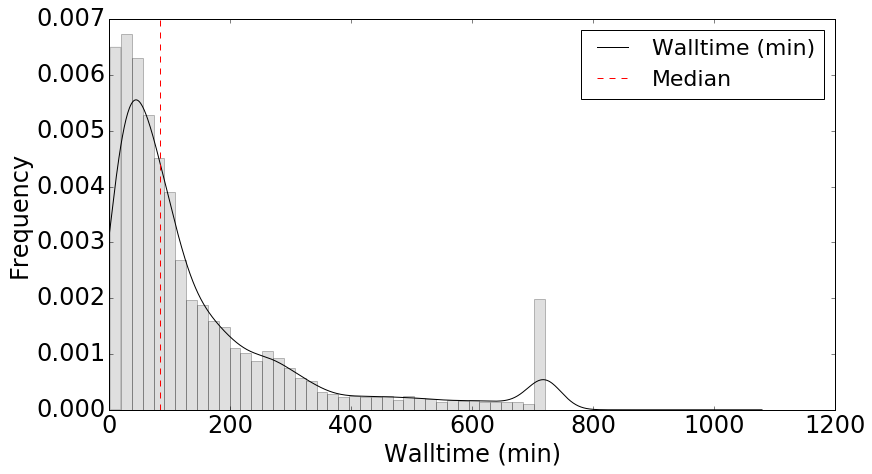

In [20]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

quo[['WALLTIME']].reset_index(drop=True).plot.density(ax=ax, 
    color='black')

quo[['WALLTIME']].reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=40, 
                alpha = 0.25,
                normed=True)

plt.axvline(quo.WALLTIME.median(), color='r', linestyle='dashed', linewidth=1)

ax.legend(labels=['Walltime (min)', 'Median'])
plt.xlabel('Walltime (min)')
ax.set_xlim(0)


(0, 6000.0)

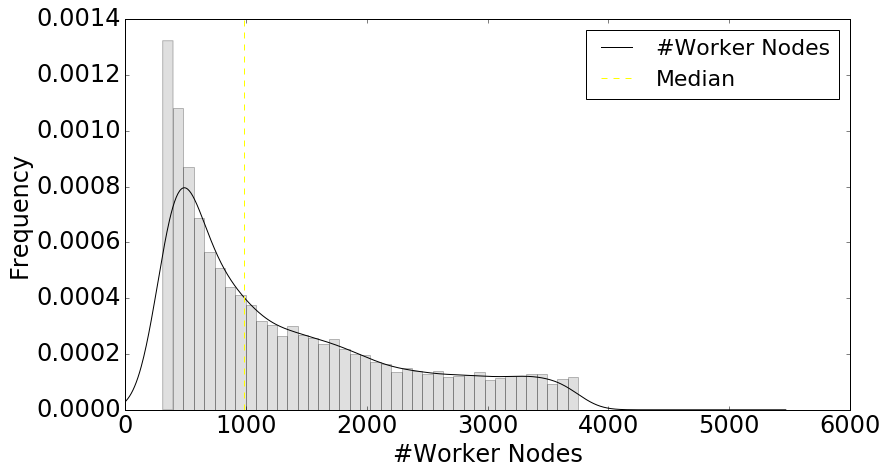

In [21]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

quo[['NODES']].reset_index(drop=True).plot.density(ax=ax, color='black')

quo[['NODES']].reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=40, 
                alpha = 0.25,
                normed=True)

plt.axvline(quo.NODES.median(), color='yellow', linestyle='dashed', linewidth=1)

ax.legend(labels=['#Worker Nodes', 'Median'])
plt.xlabel('#Worker Nodes')
ax.set_xlim(0)


## Correlation and distributions 4rd bin

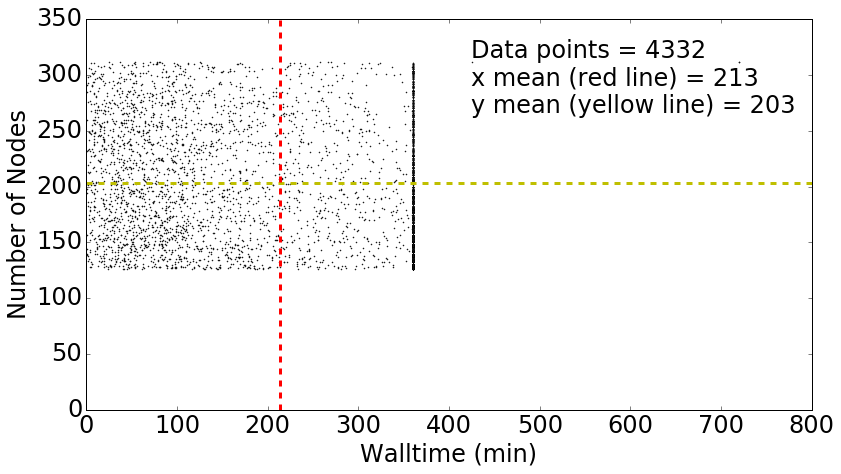

In [22]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

# title='TITAN Backfill Availability\n'+\
# 'Correlation between the number of nodes available and their walltime.'
# fig.suptitle(title)

quo = segments['4th bin\n126-312\nNodes']
ymean = quo.NODES.mean()
xmean = quo.WALLTIME.mean()

ax.scatter(quo['WALLTIME'], 
           quo['NODES'], 
           s=1, 
           facecolor='gray', lw=0.5)#, alpha=0.3, lw=0.5)

plt.axhline(quo.NODES.mean(), color='y', linestyle='dashed', linewidth=3)
plt.axvline(quo.WALLTIME.mean(), color='r', linestyle='dashed', linewidth=3)

mpl.pyplot.text(0.53, 0.95, "Data points = %s\nx mean (red line) = %s\ny mean (yellow line) = %s" % (quo.shape[0], int(xmean), int(ymean)),
    horizontalalignment='left',
    verticalalignment='top',
    transform = ax.transAxes,
    fontsize=24)

ax.set_xlim(0)
ax.set_ylim(0)

plt.xlabel('Walltime (min)')
plt.ylabel('Number of Nodes')

plt.savefig('titan_backfill_avail_3rd_bin.png', dpi=300, bbox_inches='tight')

(0, 1200.0)

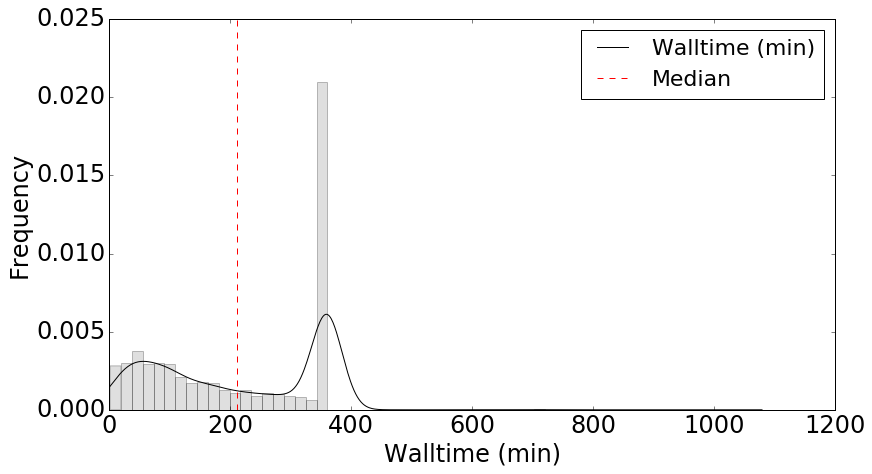

In [23]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

quo[['WALLTIME']].reset_index(drop=True).plot.density(ax=ax, 
    color='black')

quo[['WALLTIME']].reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=40, 
                alpha = 0.25,
                normed=True)

plt.axvline(quo.WALLTIME.median(), color='r', linestyle='dashed', linewidth=1)

ax.legend(labels=['Walltime (min)', 'Median'])
plt.xlabel('Walltime (min)')
ax.set_xlim(0)


(0, 450.0)

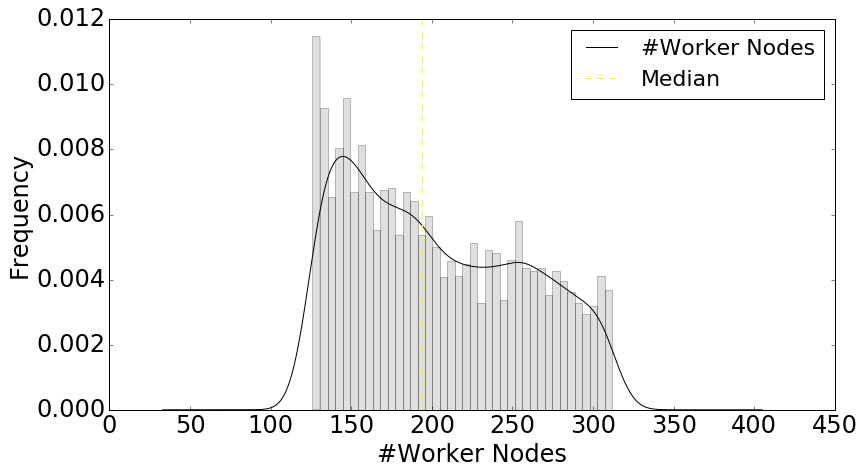

In [24]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

quo[['NODES']].reset_index(drop=True).plot.density(ax=ax, color='black')

quo[['NODES']].reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=40, 
                alpha = 0.25,
                normed=True)

plt.axvline(quo.NODES.median(), color='yellow', linestyle='dashed', linewidth=1)

ax.legend(labels=['#Worker Nodes', 'Median'])
plt.xlabel('#Worker Nodes')
ax.set_xlim(0)


## Correlation and distributions 5th bin

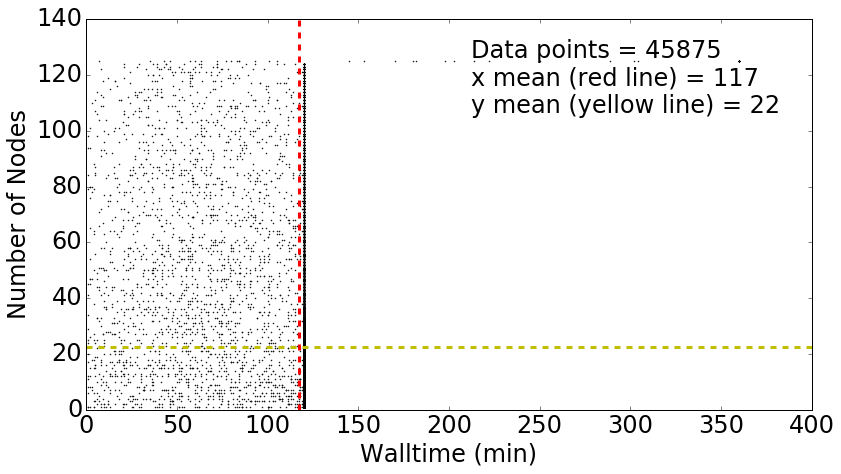

In [25]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

# title='TITAN Backfill Availability\n'+\
# 'Correlation between the number of nodes available and their walltime.'
# fig.suptitle(title)

quo = segments['5th bin\n1-125\nNodes']
ymean = quo.NODES.mean()
xmean = quo.WALLTIME.mean()

ax.scatter(quo['WALLTIME'], 
           quo['NODES'], 
           s=1, 
           facecolor='gray', lw=0.5)#, alpha=0.3, lw=0.5)

plt.axhline(quo.NODES.mean(), color='y', linestyle='dashed', linewidth=3)
plt.axvline(quo.WALLTIME.mean(), color='r', linestyle='dashed', linewidth=3)

mpl.pyplot.text(0.53, 0.95, "Data points = %s\nx mean (red line) = %s\ny mean (yellow line) = %s" % (quo.shape[0], int(xmean), int(ymean)),
    horizontalalignment='left',
    verticalalignment='top',
    transform = ax.transAxes,
    fontsize=24)

ax.set_xlim(0)
ax.set_ylim(0)

plt.xlabel('Walltime (min)')
plt.ylabel('Number of Nodes')

plt.savefig('titan_backfill_avail_3rd_bin.png', dpi=300, bbox_inches='tight')

(0, 600.0)

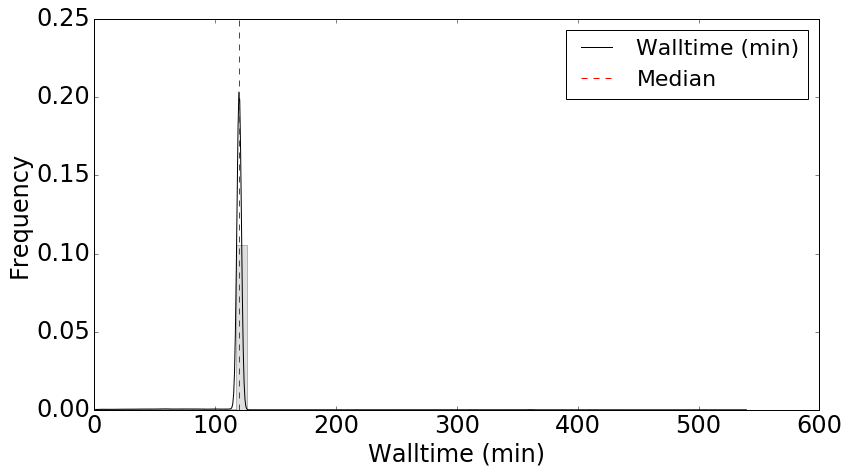

In [26]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

quo[['WALLTIME']].reset_index(drop=True).plot.density(ax=ax, 
    color='black')

quo[['WALLTIME']].reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=40, 
                alpha = 0.25,
                normed=True)

plt.axvline(quo.WALLTIME.median(), color='r', linestyle='dashed', linewidth=1)

ax.legend(labels=['Walltime (min)', 'Median'])
plt.xlabel('Walltime (min)')
ax.set_xlim(0)


(0, 200.0)

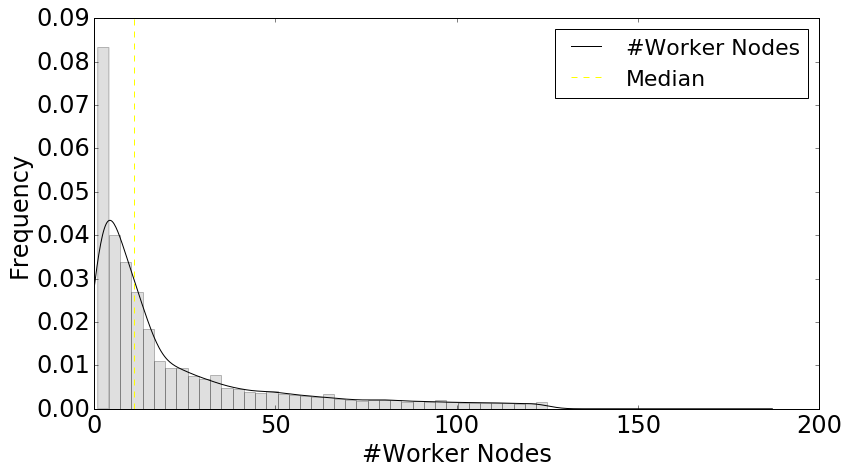

In [27]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

quo[['NODES']].reset_index(drop=True).plot.density(ax=ax, color='black')

quo[['NODES']].reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=40, 
                alpha = 0.25,
                normed=True)

plt.axvline(quo.NODES.median(), color='yellow', linestyle='dashed', linewidth=1)

ax.legend(labels=['#Worker Nodes', 'Median'])
plt.xlabel('#Worker Nodes')
ax.set_xlim(0)
